# FNN  Implementation

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
# Load dataset from hdf5 file
def load_dataset(database_path):
    # open dataset
    dataset_db = h5py.File(database_path, "r")
    datasets = {}
    for dataset in ["train", "dev", "test"]:
        # load the train set feautres (picuture)
        datasets[dataset] = {'X' : np.array(dataset_db[dataset + "_img"][:]),  # dataset features
                             'Y' : np.array(dataset_db[dataset + "_labels"][:]) # dataset labels
                            }
    return datasets

### 1. Data normalization and flattening

In [3]:
car_dataset = load_dataset('car_dataset.hdf5')

train_set_x_orig = np.array(car_dataset["train"]['X'][:])
train_set_y_orig = np.array(car_dataset["train"]['Y'][:])

dev_test_set_x_orig = np.array(car_dataset["dev"]['X'][:]) 
dev_test_set_y_orig = np.array(car_dataset["dev"]['Y'][:]) 

train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
dev_test_set_y = dev_test_set_y_orig.reshape((1, dev_test_set_y_orig.shape[0]))

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
dev_test_set_x_flatten = dev_test_set_x_orig.reshape(dev_test_set_x_orig.shape[0], -1).T 

train_set_x = train_set_x_flatten/255.
dev_test_set_x = dev_test_set_x_flatten/255.

print ("train_set_x_flatten shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("dev_test_set_x_flatten shape: " + str(dev_test_set_x.shape))
print ("dev_test_set_y shape: " + str(dev_test_set_y.shape))

test_set_x_orig = np.array(car_dataset["test"]['X'][:]) # your test set features
test_set_y_orig = np.array(car_dataset["test"]['Y'][:]) # your test set labels

test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T 
test_set_x = test_set_x_flatten/255.

print ("test_set_x_flatten shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 517)
train_set_y shape: (1, 517)
dev_test_set_x_flatten shape: (12288, 172)
dev_test_set_y shape: (1, 172)
test_set_x_flatten shape: (12288, 173)
test_set_y shape: (1, 173)


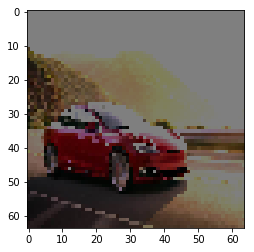

In [4]:
# Example Car Image in the dataset
index = 21
plt.imshow(train_set_x_orig[index])

## 2. Logistic Regression Implementation

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))


def initialize_with_zeros(dim):
    w = np.zeros((dim,1))
    b = 0
    return w,b


def forward_propagate(w,b,X,Y):
    m = X.shape[1]  
    Z = np.dot(w.T,X) + b
    A = sigmoid(Z)     #  activation
    cost = (-1/m) * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A)) 
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return A, cost


def backward_propagate(A, X, Y):
    m= X.shape[1]
    dZ = A - Y
   
    dw = 1/m * np.matmul(X, dZ.T)
    db = 1/m * np.sum(dZ)
    
    grads = {"dw": dw,
             "db": db} 
    
    return grads

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        
        A, cost = forward_propagate(w, b, X, Y)
        grads = backward_propagate(A, X, Y)
        
        dw = grads["dw"] 
        db = grads["db"]         
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

def predict(w, b, X):
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T,X) + b)
    
    for i in range(A.shape[1]):
        
        Y_prediction[0][i] = 1 if A[0][i]>0.5 else 0
        
    assert(Y_prediction.shape == (1, m))
    return Y_prediction
    
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
       
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent 
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = print_cost)
    
    w = parameters['w']
    b = parameters['b']

    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [6]:
print("Cost and accuracy calculations for training and dev datasets\n\n")
d = model(train_set_x, train_set_y, dev_test_set_x, dev_test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost and accuracy calculations for training and dev datasets


Cost after iteration 0: 0.693147
Cost after iteration 100: 0.348325
Cost after iteration 200: 0.293235
Cost after iteration 300: 0.263346
Cost after iteration 400: 0.242531
Cost after iteration 500: 0.226353
Cost after iteration 600: 0.213014
Cost after iteration 700: 0.201614
Cost after iteration 800: 0.191640
Cost after iteration 900: 0.182771
Cost after iteration 1000: 0.174791
Cost after iteration 1100: 0.167547
Cost after iteration 1200: 0.160925
Cost after iteration 1300: 0.154839
Cost after iteration 1400: 0.149219
Cost after iteration 1500: 0.144009
Cost after iteration 1600: 0.139162
Cost after iteration 1700: 0.134640
Cost after iteration 1800: 0.130409
Cost after iteration 1900: 0.126441
train accuracy: 97.48549323017409 %
test accuracy: 91.86046511627907 %


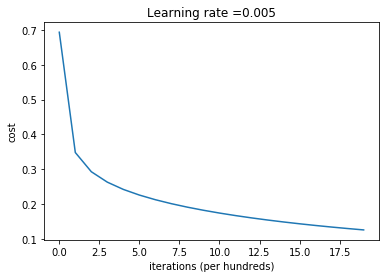

In [7]:
# Plot learning curve (with costs) for part 1
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [20]:
print("Accuracy calculations for training and test datasets\n\n")
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

Accuracy calculations for training and test datasets


train accuracy: 97.48549323017409 %
test accuracy: 89.59537572254335 %


## 3. Deep NN implementation

In [12]:
# Helper functions for FNN

def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost


def linear_forward(A, W, b):
    Z = W.dot(A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid_nn(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def sigmoid_nn(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache


def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [13]:
def initialize_parameters_deep(layer_dims):
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2 

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation='relu')

        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation='sigmoid')
    caches.append(cache)
    return AL, caches

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation='sigmoid')
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+2)], current_cache, activation='relu')
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = []                         
    parameters = initialize_parameters_deep(layers_dims)

    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

def predict_nn(X, parameters):
    probas, caches = L_model_forward(X, parameters)

    p = np.around(probas)
        
    return p

#### Training NN model with 8 and 15 nodes in first and second layers

Cost after iteration 0: 0.659334
Cost after iteration 100: 0.368408
Cost after iteration 200: 0.262234
Cost after iteration 300: 0.208532
Cost after iteration 400: 0.170345
Cost after iteration 500: 0.145620
Cost after iteration 600: 0.115264
Cost after iteration 700: 0.089939
Cost after iteration 800: 0.068380
Cost after iteration 900: 0.055652
Cost after iteration 1000: 0.045569
Cost after iteration 1100: 0.037881
Cost after iteration 1200: 0.032060
Cost after iteration 1300: 0.027689
Cost after iteration 1400: 0.024354
Cost after iteration 1500: 0.021771
Cost after iteration 1600: 0.019696
Cost after iteration 1700: 0.018016
Cost after iteration 1800: 0.016627
Cost after iteration 1900: 0.015465
Cost after iteration 2000: 0.014483
Cost after iteration 2100: 0.013644
Cost after iteration 2200: 0.012922
Cost after iteration 2300: 0.012298
Cost after iteration 2400: 0.011753
Cost after iteration 2500: 0.011273
Cost after iteration 2600: 0.010848
Cost after iteration 2700: 0.010472
Cost

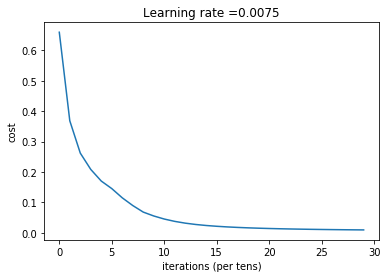

In [14]:
layers_dims = [12288,8,15,1]
# training the model for with the training set
model_parameters = L_layer_model(train_set_x, train_set_y, layers_dims, num_iterations = 3000, print_cost = True)

In [16]:
m_train = train_set_y.shape[1]
predictions_train = predict_nn(train_set_x, model_parameters)
print("Train Accuracy: "  + str(np.sum((predictions_train == train_set_y)/m_train)))

m_dev_test = dev_test_set_y.shape[1]
predictions_test = predict_nn(dev_test_set_x, model_parameters)
print("Dev Accuracy: "  + str(np.sum((predictions_test == dev_test_set_y)/m_dev_test)))

m_test = test_set_y.shape[1]
predictions_test = predict_nn(test_set_x, model_parameters)
print("Test Accuracy: "  + str(np.sum((predictions_test == test_set_y)/m_test)))

Train Accuracy: 0.9922630560928436
Dev Accuracy: 0.9360465116279069
Test Accuracy: 0.9075144508670518


### 4.1 Logistic Regression Results

Cost after 2000 iterations and learning rate 0.005 with Training set : 0.126441

Accuracy (in percent) :
<table>
    <tr>
    <td>**Train Accuracy**</td>
    <td>97.48549323017409</td>
    </tr>
    <tr>
    <td> **Dev Set Accuracy**</td>
    <td> 91.86046511627907 </td>
    </tr>
    <tr>
    <td> **Test Accuracy**</td>
    <td> 89.59537572254335 </td>
    </tr>
</table>

### 4.2 Deep NN Results

Cost after 3000 iterations and learning rate 0.0075 with Training set : 0.0.009829

Layer dimensions = [12288,8,15,1]

Accuracy (in percent) :
<table>
    <tr>
    <td>**Train Accuracy**</td>
    <td>99.22630560928436</td>
    </tr>
    <tr>
    <td> **Dev Set Accuracy**</td>
    <td> 93.60465116279069 </td>
    </tr>
    <tr>
    <td> **Test Accuracy**</td>
    <td> 90.75144508670518 </td>
    </tr>
</table>